In [1]:
import pandas as pd

import plotly.express as px
import numpy as np
import os
import seaborn as sns
sns.set_style("whitegrid")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
tqdm.pandas()
pd.options.display.max_columns = 999

import plotly.graph_objects as go
import ipyvuetify as v

from ipywidgets import interact, Checkbox, Select, Output, widgets
import ipywidgets
from datetime import datetime

from IPython.display import display

import time

In [2]:
#### Import various plot file. In case the source file is modified, please rerun preprocess.py ####

# import preprocess
# preprocess.preprocess()

In [3]:

#read continental level data
continental_flows=pd.read_csv('./plot_files/continental_flows.csv',sep=',', keep_default_na=False, na_values=['', 'NaN'], index_col=0)
continental_flows_non_dir=pd.read_csv('./plot_files/continental_flows_non_dir.csv',sep=',', keep_default_na=False, na_values=['', 'NaN'], index_col=0)
conti_scatter=pd.read_csv('./plot_files/conti_scatter.csv',sep=',', keep_default_na=False, na_values=['', 'NaN'], index_col=0)

#read country level data
country_flows=pd.read_csv('./plot_files/country_flows.csv',sep=',', keep_default_na=False, na_values=['', 'NaN'], index_col=0)
country_fixed=pd.read_csv('./plot_files/country_fixed.csv',sep=',', keep_default_na=False, na_values=['', 'NaN'], index_col=0)
country_fixed_sep_dom=pd.read_csv('./plot_files/country_fixed_sep_dom.csv',sep=',', keep_default_na=False, na_values=['', 'NaN'], index_col=0)

#read flight_level_data
flights_df=pd.read_csv('./plot_files/flights_df.zip',compression='zip', sep=',',keep_default_na=False, na_values=['', 'NaN'], index_col=0)

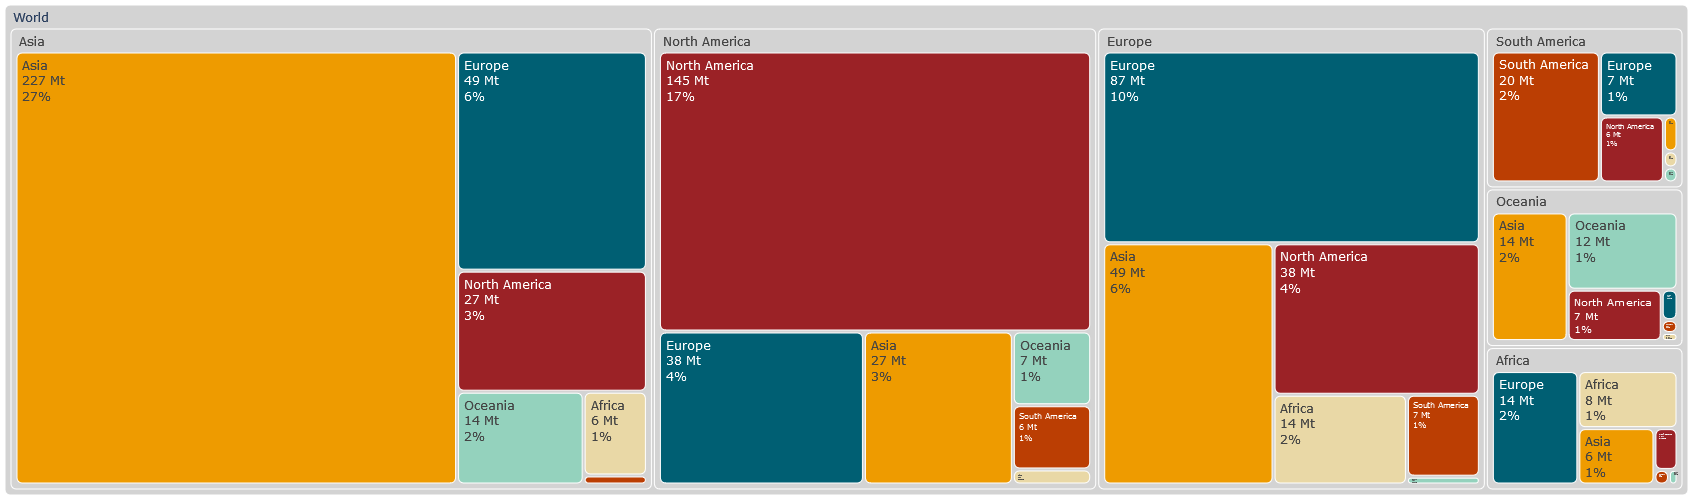

In [4]:
color_discrete_map = {
    "AS": "#EE9B00",
    "AF": "#E9D8A6",
    "EU": "#005F73",
    "NA": "#9B2226",
    "OC": "#94D2BD",
    "SA": "#BB3E03",
    "(?)": "lightgrey",
}


fig = px.treemap(
            continental_flows,
            path=[
                px.Constant("World"),
                "departure_continent_name",
                "arrival_continent_name",
            ],
            values='CO2 (Mt)',
            color="arrival_continent",
            color_discrete_map=color_discrete_map,
        )

fig.update_layout(margin=dict(l=5, r=5, t=5, b=5), height=500, width=1000)

fig.update_traces(
                hovertemplate="Flow=%{id}<br>CO<sub>2</sub>=%{value:.2f} (Mt)"
            )
fig.update_traces(
    marker=dict(cornerradius=5),
    textinfo="label+value+percent entry",
    texttemplate="%{label}<br>%{value:.0f} Mt<br>%{percentEntry}",
)

fig.write_image('treemap.pdf', format='pdf')
fig

## A- Aircraft potential

In this section, AeroSCOPE is use dto evaluate te decarbonization potential of various alternative aircarft types (hydrgen aircraft, electric aircraft) at the global level.  
Then a similar analysis is conducted for two individual countries, Netherlands and Norway.  
_Since switching to hydrogen aviation will require high equipment cost, wee also look at thenumber of airporst to equip??_


* Hydrogen aircraft: <br> The aim of this artcile is not to provide a performance analysis of future hydrogen aircraft concepts. We will rely on Airbus ZeroE targets to define two aicraft nominal range. (https://www.airbus.com/en/innovation/low-carbon-aviation/hydrogen/zeroe)
    - 1000NM : Short range turboprop or fuel cell electric, 100 pax 
    - 2000NM : Short-Medium range turbofan (conventional or blended wing body), 150 pax 

* Battery electric aircraft: <br> hypothesis based on central case of https://www.sciencedirect.com/science/article/pii/S0376042118301179?via%3Dihub
    - 500NM : Ultra short range 180 pax




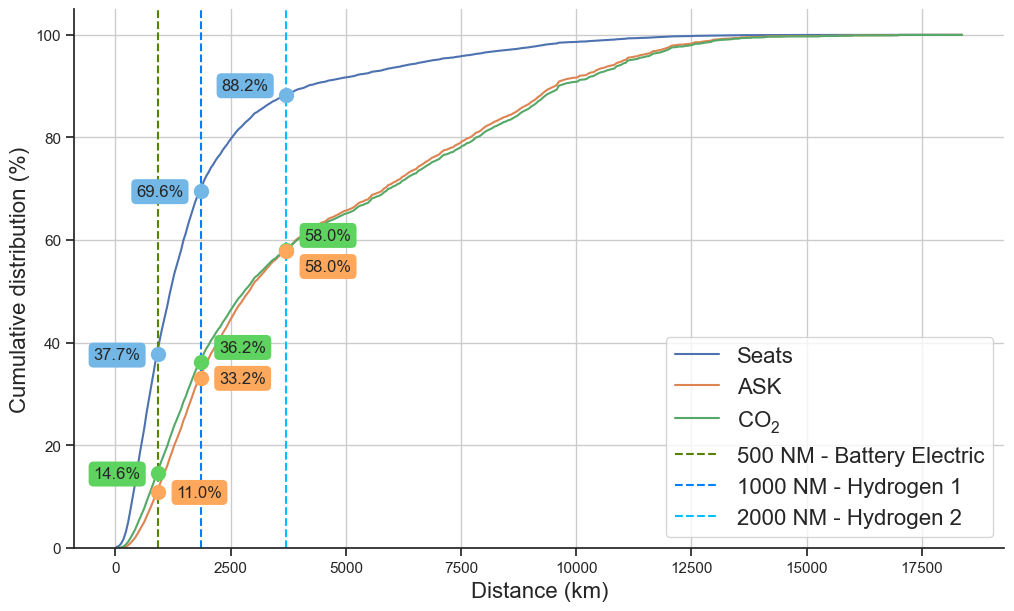

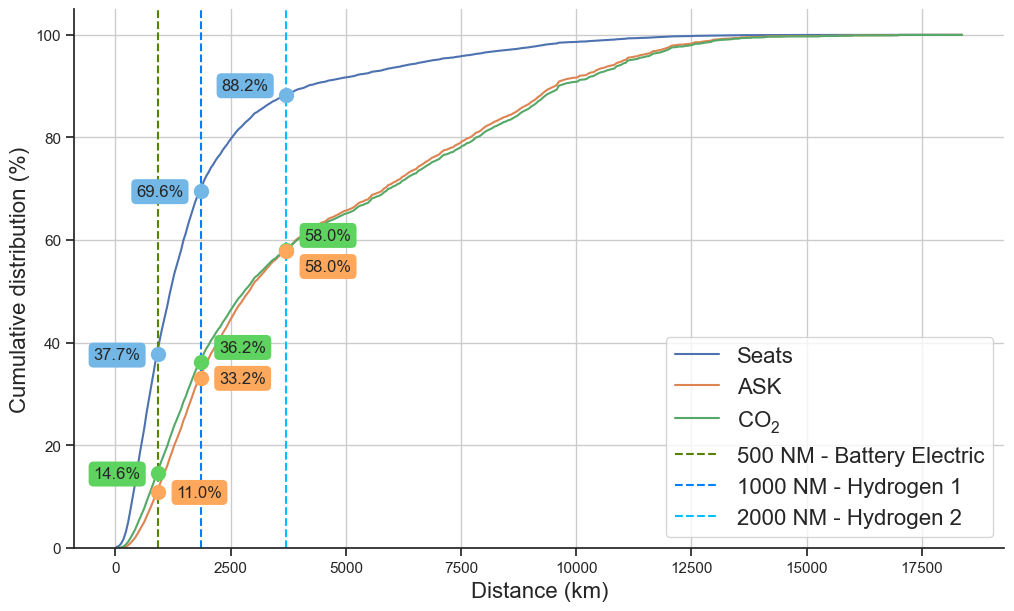

In [5]:
%matplotlib inline

#Directly using AeroSCOPE plot

# sns.set_style("whitegrid")
# Create a new figure with a single subplot
fig, ax = plt.subplots(figsize=(12,7))
sns.histplot(flights_df, x='distance_km', weights='seats', label='Seats', element='poly',fill=False, cumulative = True, stat='percent', ax=ax,bins=range(0, int(flights_df["distance_km"].max()) + 50, 50),)
sns.histplot(flights_df, x='distance_km', weights='ask', label= 'ASK', element='poly',fill=False, cumulative = True, stat='percent',ax=ax,bins=range(0, int(flights_df["distance_km"].max()) + 50, 50),)
sns.histplot(flights_df, x='distance_km', weights='co2', label= '$\mathregular{CO_2}$', element='poly',fill=False, cumulative = True, stat='percent', ax=ax,bins=range(0, int(flights_df["distance_km"].max()) + 50, 50),)

ax.legend()

# Set the title, x-axis label, and y-axis label
# ax.set_title("Metrics cumulative distribution vs flight distance", fontsize=16)
ax.set_xlabel("Distance (km)", fontsize=16)
ax.set_ylabel("Cumulative distribution (%)", fontsize=16)
ax.grid()


# Add vertical lines at 500, 1000, and 2000 NM
ax.axvline(x=500*1.852, color='#568203', linestyle='--', label='500 NM - Battery Electric')
ax.axvline(x=1000*1.852, color='#007FFF', linestyle='--', label='1000 NM - Hydrogen 1 ')
ax.axvline(x=2000*1.852, color='#00BFFF', linestyle='--', label='2000 NM - Hydrogen 2')





# Find the corresponding y-value at the intersection point
y_value = np.interp(500*1.852, flights_df['distance_km'].sort_values(), np.cumsum(flights_df.sort_values(by='distance_km')['co2'])/sum(flights_df['co2'])*100)
ax.scatter(500*1.852, y_value, marker='o',s=100, zorder=5, color='#5FD35F')
ax.annotate(f'{y_value:.1f}%', xy=(500*1.852-1400, y_value-1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#5FD35F'))

y_value = np.interp(1000*1.852, flights_df['distance_km'].sort_values(), np.cumsum(flights_df.sort_values(by='distance_km')['co2'])/sum(flights_df['co2'])*100)
ax.scatter(1000*1.852, y_value, marker='o',s=100, zorder=5, color='#5FD35F') 
ax.annotate(f'{y_value:.1f}%', xy=(1000*1.852+400, y_value+2),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#5FD35F'))


y_value = np.interp(2000*1.852, flights_df['distance_km'].sort_values(), np.cumsum(flights_df.sort_values(by='distance_km')['co2'])/sum(flights_df['co2'])*100)
ax.scatter(2000*1.852, y_value, marker='o',s=100, zorder=5, color='#5FD35F')  
ax.annotate(f'{y_value:.1f}%', xy=(2000*1.852+400, y_value+2),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#5FD35F'))




# SEATS 

# Find the corresponding y-value at the intersection point
y_value = np.interp(500*1.852, flights_df['distance_km'].sort_values(), np.cumsum(flights_df.sort_values(by='distance_km')['seats'])/sum(flights_df['seats'])*100)
ax.scatter(500*1.852, y_value, marker='o',s=100, zorder=5, color='#73B7E7')
ax.annotate(f'{y_value:.1f}%', xy=(500*1.852-1400, y_value-1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#73B7E7'))

y_value = np.interp(1000*1.852, flights_df['distance_km'].sort_values(), np.cumsum(flights_df.sort_values(by='distance_km')['seats'])/sum(flights_df['seats'])*100)
ax.scatter(1000*1.852, y_value, marker='o',s=100, zorder=5, color='#73B7E7') 
ax.annotate(f'{y_value:.1f}%', xy=(1000*1.852-1400, y_value-1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#73B7E7'))


y_value = np.interp(2000*1.852, flights_df['distance_km'].sort_values(), np.cumsum(flights_df.sort_values(by='distance_km')['seats'])/sum(flights_df['seats'])*100)
ax.scatter(2000*1.852, y_value, marker='o',s=100, zorder=5, color='#73B7E7')  
ax.annotate(f'{y_value:.1f}%', xy=(2000*1.852-1400, y_value+1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#73B7E7'))



# ASK
# Find the corresponding y-value at the intersection point
y_value = np.interp(500*1.852, flights_df['distance_km'].sort_values(), np.cumsum(flights_df.sort_values(by='distance_km')['ask'])/sum(flights_df['ask'])*100)
ax.scatter(500*1.852, y_value, marker='o',s=100, zorder=5, color='#FFA85C')
ax.annotate(f'{y_value:.1f}%', xy=(500*1.852+400, y_value-1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#FFA85C'))

y_value = np.interp(1000*1.852, flights_df['distance_km'].sort_values(), np.cumsum(flights_df.sort_values(by='distance_km')['ask'])/sum(flights_df['ask'])*100)
ax.scatter(1000*1.852, y_value, marker='o',s=100, zorder=5, color='#FFA85C') 
ax.annotate(f'{y_value:.1f}%', xy=(1000*1.852+400, y_value-1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#FFA85C'))


y_value = np.interp(2000*1.852, flights_df['distance_km'].sort_values(), np.cumsum(flights_df.sort_values(by='distance_km')['ask'])/sum(flights_df['ask'])*100)
ax.scatter(2000*1.852, y_value, marker='o',s=100, zorder=5, color='#FFA85C')  
ax.annotate(f'{y_value:.1f}%', xy=(2000*1.852+400, y_value-4),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#FFA85C'))



ax.legend(title_fontsize=14, fontsize=16)

fig.savefig('metric_repartition.pdf', bbox_inches='tight')
fig

As we can see in the plot above, although adressing a substantial share of the journeys, the 500 NM electric aircraft is only able to adress 14.8% of the emissions. 
Please keep in mind that this is only a simplified anlysis. 
Notbaly, two limitations exists:
-  We are not looking at these substitution aircraft performances but only at the potential market size. 
-  The network is not considered. reaching 100% of their potential would likely isolate aircraft on singles routes, which is unrealistic.

## B- Country comparison 
Now, we modify AeroMAPS original subplot to explore the potential of alternative aircrfat in two very diffrent european countries: the Netherlands and Norway

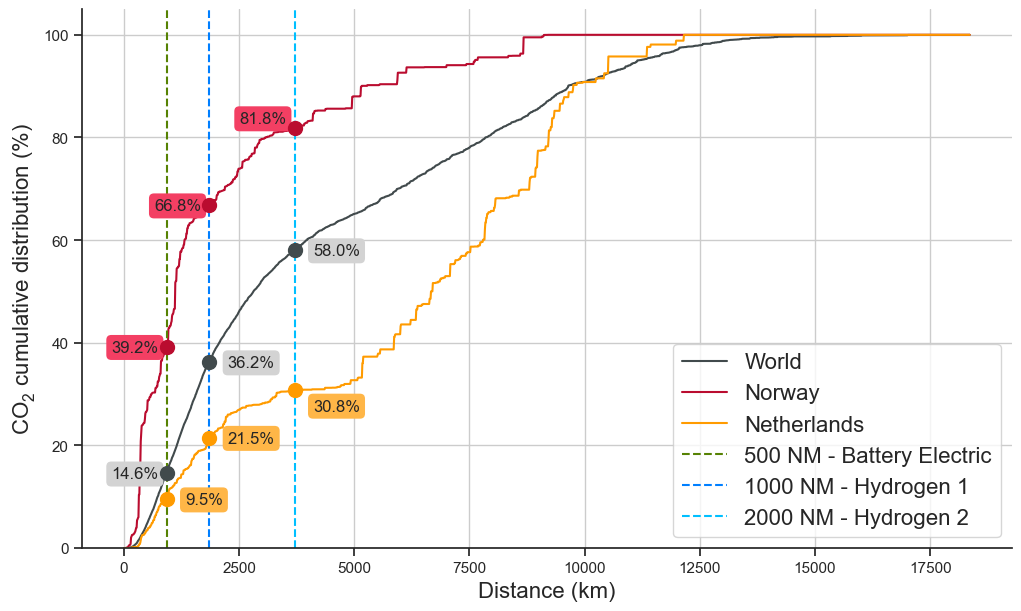

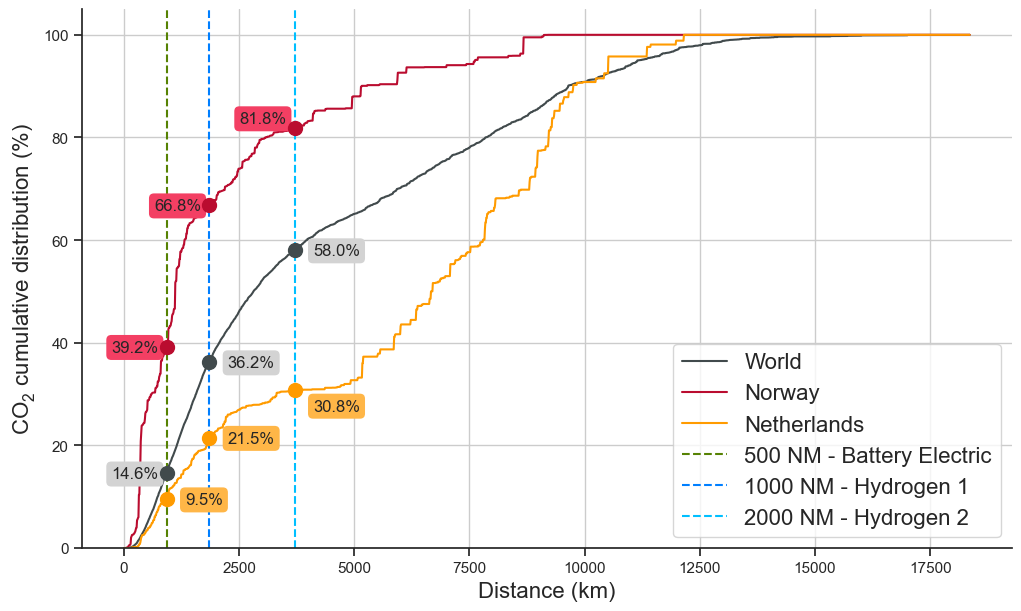

In [6]:
flights_NO= flights_df[flights_df['departure_country']=='NO'].reset_index()
flights_NL= flights_df[flights_df['departure_country']=='NL'].reset_index()

# sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12,7))
sns.histplot(flights_df, x='distance_km', weights='co2', label='World', element='poly',fill=False,color='#414A4C', cumulative = True, stat='percent', ax=ax,bins=range(0, int(flights_df["distance_km"].max()) + 10, 10),)
sns.histplot(flights_NO, x='distance_km', weights='co2', label= 'Norway', element='poly',fill=False, color='#BA0C2F', cumulative = True, stat='percent',ax=ax,bins=range(0, int(flights_df["distance_km"].max()) + 10, 10),)
sns.histplot(flights_NL, x='distance_km', weights='co2', label= 'Netherlands', element='poly',fill=False,color='#FF9B00', cumulative = True, stat='percent', ax=ax,bins=range(0, int(flights_df["distance_km"].max()) + 10, 10),)

ax.legend()

# Set the title, x-axis label, and y-axis label
# ax.set_title("$\mathregular{CO_2}$ cumulative distribution vs flight distance", fontsize=16)
ax.set_xlabel("Distance (km)", fontsize=16)
ax.set_ylabel("$\mathregular{CO_2}$ cumulative distribution (%)", fontsize=16)


# Add vertical lines at 500, 1000, and 2000 NM
ax.axvline(x=500*1.852, color='#568203', linestyle='--', label='500 NM - Battery Electric')
ax.axvline(x=1000*1.852, color='#007FFF', linestyle='--', label='1000 NM - Hydrogen 1 ')
ax.axvline(x=2000*1.852, color='#00BFFF', linestyle='--', label='2000 NM - Hydrogen 2')


# Find the corresponding y-value at the intersection point
y_value = np.interp(500*1.852, flights_df['distance_km'].sort_values(), np.cumsum(flights_df.sort_values(by='distance_km')['co2'])/sum(flights_df['co2'])*100)
ax.scatter(500*1.852, y_value, marker='o',s=100, zorder=5, color='#414A4C')
ax.annotate(f'{y_value:.1f}%', xy=(500*1.852-1200, y_value-1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='lightgray'))

y_value = np.interp(1000*1.852, flights_df['distance_km'].sort_values(), np.cumsum(flights_df.sort_values(by='distance_km')['co2'])/sum(flights_df['co2'])*100)
ax.scatter(1000*1.852, y_value, marker='o',s=100, zorder=5, color='#414A4C') 
ax.annotate(f'{y_value:.1f}%', xy=(1000*1.852+400, y_value-1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='lightgray'))


y_value = np.interp(2000*1.852, flights_df['distance_km'].sort_values(), np.cumsum(flights_df.sort_values(by='distance_km')['co2'])/sum(flights_df['co2'])*100)
ax.scatter(2000*1.852, y_value, marker='o',s=100, zorder=5, color='#414A4C')  
ax.annotate(f'{y_value:.1f}%', xy=(2000*1.852+400, y_value-1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='lightgray'))




# NORWAY 

# Find the corresponding y-value at the intersection point
y_value = np.interp(500*1.852, flights_NO['distance_km'].sort_values(), np.cumsum(flights_NO.sort_values(by='distance_km')['co2'])/sum(flights_NO['co2'])*100)
ax.scatter(500*1.852, y_value, marker='o',s=100, zorder=5, color='#BA0C2F')
ax.annotate(f'{y_value:.1f}%', xy=(500*1.852-1200, y_value-1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#F33F63'))

y_value = np.interp(1000*1.852, flights_NO['distance_km'].sort_values(), np.cumsum(flights_NO.sort_values(by='distance_km')['co2'])/sum(flights_NO['co2'])*100)
ax.scatter(1000*1.852, y_value, marker='o',s=100, zorder=5, color='#BA0C2F') 
ax.annotate(f'{y_value:.1f}%', xy=(1000*1.852-1200, y_value-1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#F33F63'))


y_value = np.interp(2000*1.852, flights_NO['distance_km'].sort_values(), np.cumsum(flights_NO.sort_values(by='distance_km')['co2'])/sum(flights_NO['co2'])*100)
ax.scatter(2000*1.852, y_value, marker='o',s=100, zorder=5, color='#BA0C2F')  
ax.annotate(f'{y_value:.1f}%', xy=(2000*1.852-1200, y_value+1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#F33F63'))



# NETHERLANDS
# Find the corresponding y-value at the intersection point
y_value = np.interp(500*1.852, flights_NL['distance_km'].sort_values(), np.cumsum(flights_NL.sort_values(by='distance_km')['co2'])/sum(flights_NL['co2'])*100)
ax.scatter(500*1.852, y_value, marker='o',s=100, zorder=5, color='#FF9B00')
ax.annotate(f'{y_value:.1f}%', xy=(500*1.852+400, y_value-1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#FFB647'))

y_value = np.interp(1000*1.852, flights_NL['distance_km'].sort_values(), np.cumsum(flights_NL.sort_values(by='distance_km')['co2'])/sum(flights_NL['co2'])*100)
ax.scatter(1000*1.852, y_value, marker='o',s=100, zorder=5, color='#FF9B00') 
ax.annotate(f'{y_value:.1f}%', xy=(1000*1.852+400, y_value-1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#FFB647'))


y_value = np.interp(2000*1.852, flights_NL['distance_km'].sort_values(), np.cumsum(flights_NL.sort_values(by='distance_km')['co2'])/sum(flights_NL['co2'])*100)
ax.scatter(2000*1.852, y_value, marker='o',s=100, zorder=5, color='#FF9B00')  
ax.annotate(f'{y_value:.1f}%', xy=(2000*1.852+400, y_value-4),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#FFB647'))

ax.legend(fontsize=16)
ax.grid()
fig.savefig('repartition.pdf', bbox_inches='tight')
fig

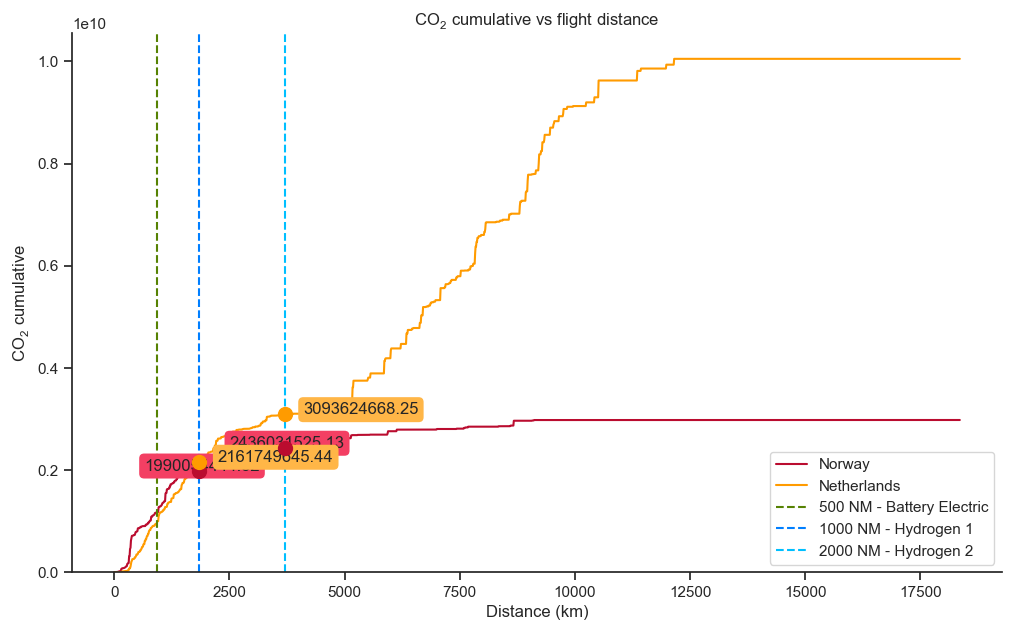

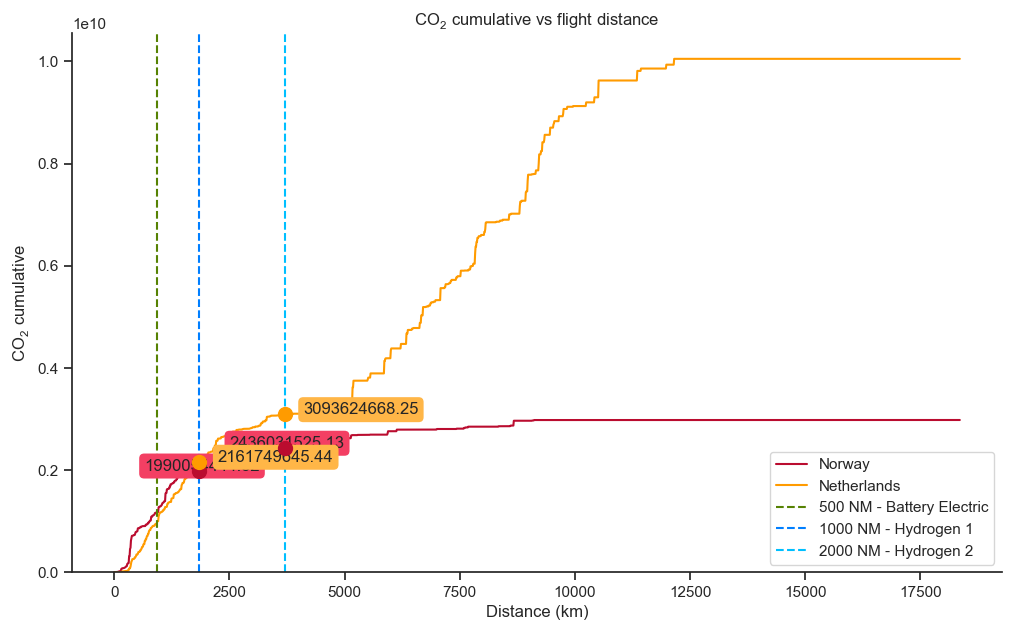

In [7]:
flights_NO= flights_df[flights_df['departure_country']=='NO'].reset_index()
flights_NL= flights_df[flights_df['departure_country']=='NL'].reset_index()

# sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12,7))
sns.histplot(flights_NO, x='distance_km', weights='co2', label= 'Norway', element='poly',fill=False, color='#BA0C2F', cumulative = True, ax=ax,bins=range(0, int(flights_df["distance_km"].max()) + 10, 10),)
sns.histplot(flights_NL, x='distance_km', weights='co2', label= 'Netherlands', element='poly',fill=False,color='#FF9B00', cumulative = True, ax=ax,bins=range(0, int(flights_df["distance_km"].max()) + 10, 10),)

ax.legend()

# Set the title, x-axis label, and y-axis label
ax.set_title("$\mathregular{CO_2}$ cumulative vs flight distance")
ax.set_xlabel("Distance (km)")
ax.set_ylabel("$\mathregular{CO_2}$ cumulative ")


# Add vertical lines at 500, 1000, and 2000 NM
ax.axvline(x=500*1.852, color='#568203', linestyle='--', label='500 NM - Battery Electric')
ax.axvline(x=1000*1.852, color='#007FFF', linestyle='--', label='1000 NM - Hydrogen 1 ')
ax.axvline(x=2000*1.852, color='#00BFFF', linestyle='--', label='2000 NM - Hydrogen 2')



# NORWAY 

y_value = np.interp(1000*1.852, flights_NO['distance_km'].sort_values(), np.cumsum(flights_NO.sort_values(by='distance_km')['co2']))
ax.scatter(1000*1.852, y_value, marker='o',s=100, zorder=5, color='#BA0C2F') 
ax.annotate(f'{y_value:.2f}', xy=(1000*1.852-1200, y_value-1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#F33F63'))


y_value = np.interp(2000*1.852, flights_NO['distance_km'].sort_values(), np.cumsum(flights_NO.sort_values(by='distance_km')['co2']))
ax.scatter(2000*1.852, y_value, marker='o',s=100, zorder=5, color='#BA0C2F')  
ax.annotate(f'{y_value:.2f}', xy=(2000*1.852-1200, y_value+1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#F33F63'))



# NETHERLANDS

y_value = np.interp(1000*1.852, flights_NL['distance_km'].sort_values(), np.cumsum(flights_NL.sort_values(by='distance_km')['co2']))
ax.scatter(1000*1.852, y_value, marker='o',s=100, zorder=5, color='#FF9B00') 
ax.annotate(f'{y_value:.2f}', xy=(1000*1.852+400, y_value-1),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#FFB647'))


y_value = np.interp(2000*1.852, flights_NL['distance_km'].sort_values(), np.cumsum(flights_NL.sort_values(by='distance_km')['co2']))
ax.scatter(2000*1.852, y_value, marker='o',s=100, zorder=5, color='#FF9B00')  
ax.annotate(f'{y_value:.2f}', xy=(2000*1.852+400, y_value-4),
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#FFB647'))



ax.legend()
fig

As we can see in the plot above, Norway is highly dominated by short haul routes, and it would be even more impressive if one used the number of available seats as a metric.   
On the other hand, the netherlands have practically no domestic aviation and Amtsterdam is a major international hub severd by many long haul routes. 

If one is to think about each country decarbonisation plans, this information is very insightfull. In a simplified case where all of these routes would be served by an airline served in this country, Norway could adress 40% of their emissions using an electric aircraft and 82% using hydrogen aircraft, while these values fall to 9.5 and 31% n the second case. 

Once again, the aim of the study is not to focus on the related carbon abatement. 
According to https://app.electricitymaps.com/, the Norwegian electricity emission factor was 35 gCO2/kWh in 2019, while netherlands were producing electricity at 407 gCO2/kWh. This increse the gap highlighted above. Howver, this is of limited interest, and 2030-2050 emissions factors should be considered instead, and that is the focus of AeroMAPS.



In [8]:

##
flights_NL_g = flights_NL.groupby(['iata_departure','iata_arrival']).agg({
    'co2': 'sum',
    'ask': 'sum',
    'seats': 'sum',
    'arrival_lon': 'first',
    'arrival_lat': 'first',
    'departure_lon': 'first',
    'departure_lat': 'first',
    
'distance_km': 'first'}).reset_index()

flights_NL_g.sort_values(by='co2').nlargest(350,columns='co2')['co2'].sum()/flights_NL_g['co2'].sum()
flights_NL_g_top=flights_NL_g#.sort_values(by='co2').nlargest(350,columns='co2').reset_index()



flights_NO_g = flights_NO.groupby(['iata_departure','iata_arrival']).agg({
    'co2': 'sum',
    'ask': 'sum',
    'seats': 'sum',
    'arrival_lon': 'first',
    'arrival_lat': 'first',
    'departure_lon': 'first',
    'departure_lat': 'first',
    
'distance_km': 'first'}).reset_index()

flights_NO_g.sort_values(by='co2').nlargest(350,columns='co2')['co2'].sum()/flights_NO_g['co2'].sum()
flights_NO_g_top=flights_NO_g#.sort_values(by='co2').nlargest(350,columns='co2').reset_index()


fl_g=pd.concat([flights_NL_g, flights_NO_g])

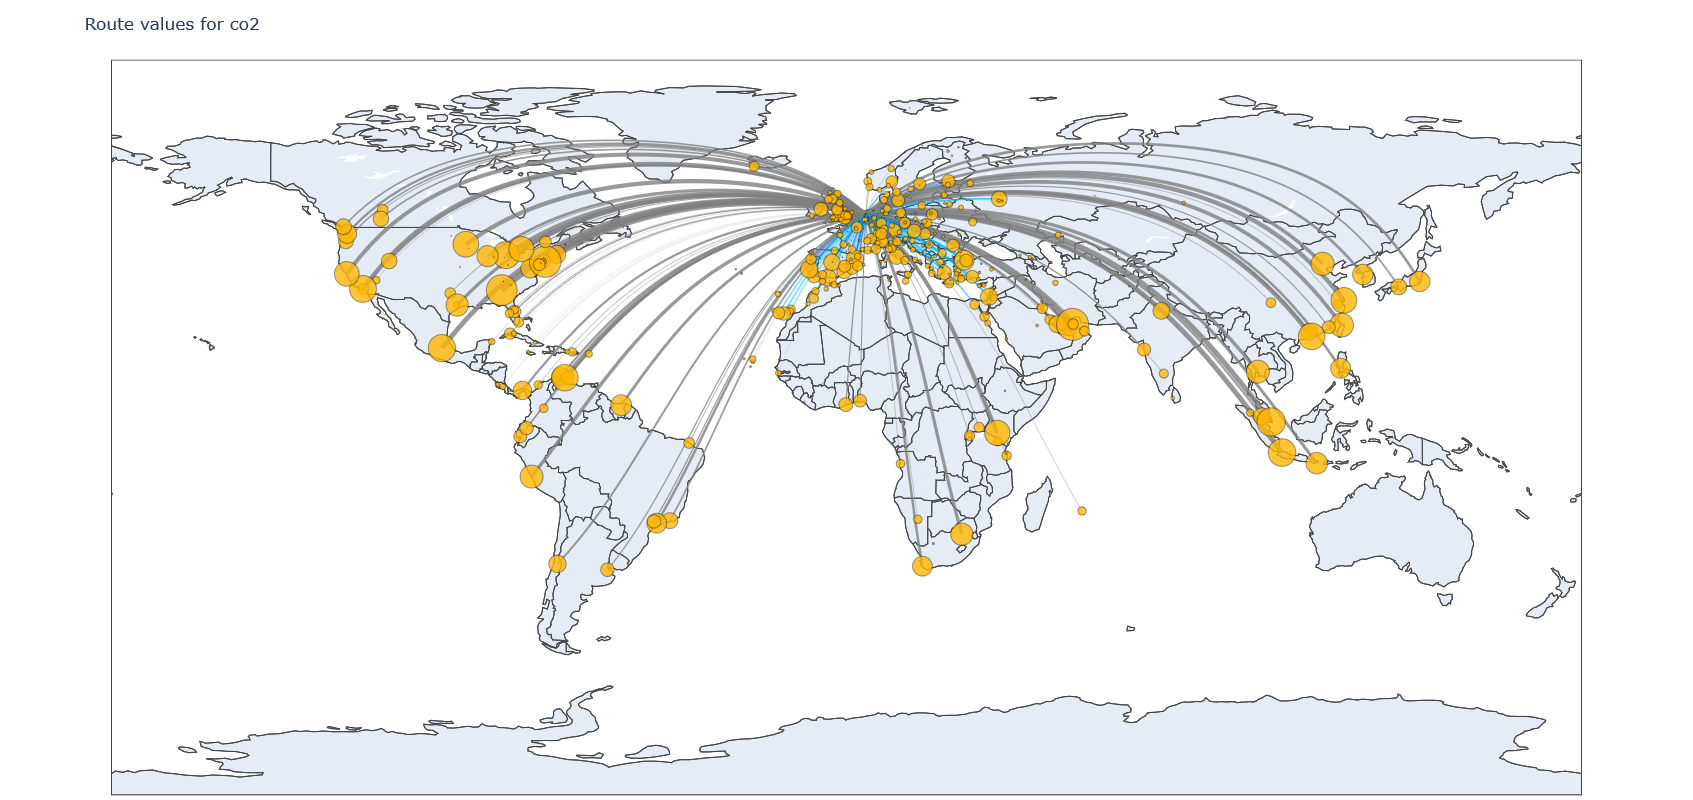

In [9]:
flights_NL_g_top['color']='gray'


def color_picker(d):
    d=d/1.852
    if d<500:
        color='#568203'
        # color=f'rgba(0,0,0,0)'
    elif 500<=d<1000:
        color='#007FFF'
        # color=f'rgba(0,0,0,0)'
    elif 1000<=d<2000:
        color='#00BFFF'
        # color=f'rgba(0,0,0,0)'
    else:
        color='gray'
        # color=f'rgba(0,0,0,0)'
    return color
    

flights_NL_g_top['color']=flights_NL_g_top.apply(lambda x: color_picker(x['distance_km']), axis=1)




value_watched_flights='co2'
flights_gpb_df=flights_NL_g_top

# Create the scattergeo figure
fig = go.Figure()

meanwidth = flights_gpb_df[value_watched_flights].mean()

for i in range(len(flights_gpb_df)):
    fig.add_trace(
        go.Scattergeo(
            lon=[flights_gpb_df['departure_lon'][i], flights_gpb_df['arrival_lon'][i]],
            lat=[flights_gpb_df['departure_lat'][i], flights_gpb_df['arrival_lat'][i]],
            mode='lines',
            line=dict(width=flights_gpb_df[value_watched_flights][i] / (3*meanwidth), color=flights_gpb_df['color'][i]),
            opacity=0.8
        )
    )

# group by airport

airport_df = flights_gpb_df.groupby('iata_arrival').agg({
    'co2': 'sum',
    'ask': 'sum',
    'seats': 'sum',
    'arrival_lon': 'first',
    'arrival_lat': 'first'}).reset_index()

fig.add_trace(go.Scattergeo(
    lon=airport_df['arrival_lon'],
    lat=airport_df['arrival_lat'],
    hoverinfo='text',
    text=airport_df[value_watched_flights],
    mode='markers',
    marker=dict(
        size=airport_df[value_watched_flights] / (.07 * fl_g[value_watched_flights].mean()),
        color='#ffb703',
        sizemode='area',
        opacity=0.8,
        line=dict(width=0.5, color='black'),
    ),
    customdata=airport_df['iata_arrival'],
    hovertemplate="Flights to: " + "%{customdata}<br>" +
                  value_watched_flights + ": %{text:.0f}<br>" +
                  "<extra></extra>",

))


fig.update_geos(showcountries=True)
fig.update_layout(showlegend=False, height=800, title='Route values for {}'.format(value_watched_flights))
fig.update_layout(margin=dict(l=5, r=5, t=60, b=5))  # Adjust layout margins and padding


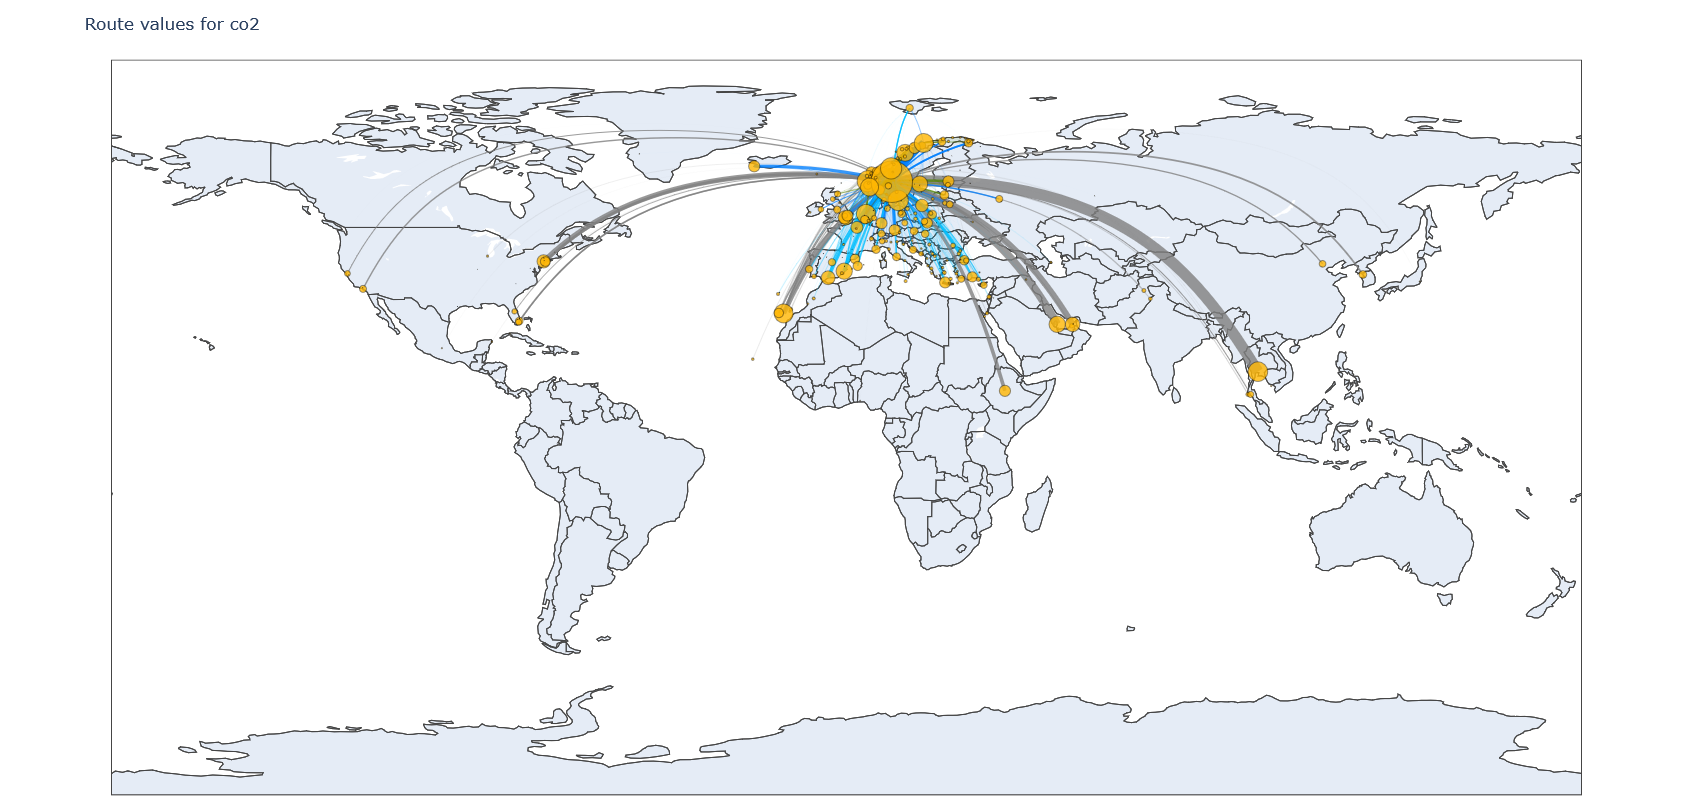

In [10]:
flights_NO_g_top['color']='gray'


def color_picker(d):
    d=d/1.852
    if d<500:
        color='#568203'
        # color=f'rgba(0,0,0,0)'
    elif 500<=d<1000:
        color='#007FFF'
        # color=f'rgba(0,0,0,0)'
    elif 1000<=d<2000:
        color='#00BFFF'
        # color=f'rgba(0,0,0,0)'
    else:
        color='gray'
        # color=f'rgba(0,0,0,0)'
    return color
    

flights_NO_g_top['color']=flights_NO_g_top.apply(lambda x: color_picker(x['distance_km']), axis=1)




value_watched_flights='co2'
flights_gpb_df=flights_NO_g_top

# Create the scattergeo figure
fig = go.Figure()

meanwidth = flights_gpb_df[value_watched_flights].mean()

for i in range(len(flights_gpb_df)):
    fig.add_trace(
        go.Scattergeo(
            lon=[flights_gpb_df['departure_lon'][i], flights_gpb_df['arrival_lon'][i]],
            lat=[flights_gpb_df['departure_lat'][i], flights_gpb_df['arrival_lat'][i]],
            mode='lines',
            line=dict(width=flights_gpb_df[value_watched_flights][i] / (3*meanwidth), color=flights_gpb_df['color'][i]),
            opacity=0.8
        )
    )

# group by airport

airport_df = flights_gpb_df.groupby('iata_arrival').agg({
    'co2': 'sum',
    'ask': 'sum',
    'seats': 'sum',
    'arrival_lon': 'first',
    'arrival_lat': 'first'}).reset_index()

fig.add_trace(go.Scattergeo(
    lon=airport_df['arrival_lon'],
    lat=airport_df['arrival_lat'],
    hoverinfo='text',
    text=airport_df[value_watched_flights],
    mode='markers',
    marker=dict(
        size=airport_df[value_watched_flights] / (.07 * fl_g[value_watched_flights].mean()),
        color='#ffb703',
        sizemode='area',
        opacity=0.8,
        line=dict(width=0.5, color='black'),
    ),
    customdata=airport_df['iata_arrival'],
    hovertemplate="Flights to: " + "%{customdata}<br>" +
                  value_watched_flights + ": %{text:.0f}<br>" +
                  "<extra></extra>",

))


fig.update_geos(showcountries=True)
fig.update_layout(showlegend=False, height=800, title='Route values for {}'.format(value_watched_flights))
fig.update_layout(margin=dict(l=5, r=5, t=60, b=5))  # Adjust layout margins and padding

## C - Maximizing the percentage of flights of each type covered.

### a) Naive approach

In [11]:
flights_df_gp= flights_df.groupby(['iata_departure','iata_arrival']).agg({
    'co2': 'sum',
    'ask': 'sum',
    'seats': 'sum',
    'arrival_lon': 'first',
    'arrival_lat': 'first',
    'departure_lon': 'first',
    'departure_lat': 'first',
    
'distance_km': 'first'}).reset_index()


flights_df_gp_elec=flights_df_gp[flights_df_gp.distance_km<500*1.852]

flights_df_gp_h2=flights_df_gp[(flights_df_gp.distance_km>=500*1.852) & (flights_df_gp.distance_km<1000*1.852)]

flights_df_gp_h2_bis=flights_df_gp[(flights_df_gp.distance_km>=500*1.852) & (flights_df_gp.distance_km<2000*1.852)]

In [12]:
print('Number of OD pairs overall: {}'.format(len(flights_df_gp)))
print('Number of OD pairs OK for battery elec: {}'.format(len(flights_df_gp_elec)))
print('Number of OD pairs OK for hydrogen 1000NM: {}'.format(len(flights_df_gp_h2)))
print('Number of OD pairs OK for hydrogen 2000NM: {}'.format(len(flights_df_gp_h2_bis)))

Number of OD pairs overall: 118226
Number of OD pairs OK for battery elec: 45028
Number of OD pairs OK for hydrogen 1000NM: 33494
Number of OD pairs OK for hydrogen 2000NM: 58820


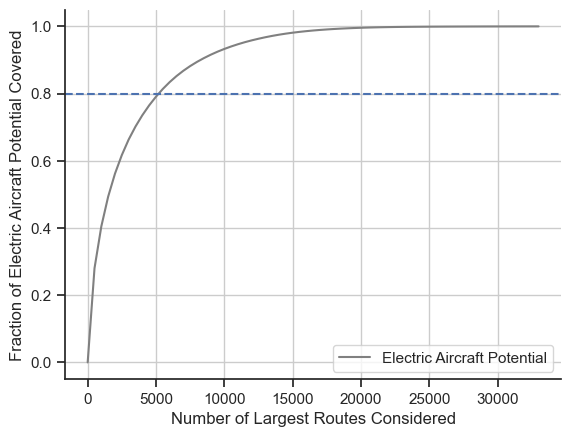

In [13]:
flights_df_gp_elec

score=[]
x=[]

for i in range (0, 33494, 500):
    x.append(i)
    score.append(flights_df_gp_elec.sort_values(by='co2').nlargest(i,columns='co2')['co2'].sum()/flights_df_gp_elec['co2'].sum())
    

fig, ax = plt.subplots()
ax.plot(x, score, color='grey', linestyle='-', label='Electric Aircraft Potential')
ax.grid()

ax.axhline(y=0.8, linestyle='--')

plt.xlabel('Number of Largest Routes Considered')
plt.ylabel('Fraction of Electric Aircraft Potential Covered')
plt.legend()
    
flights_df_gp_elec_top=flights_df_gp_elec.sort_values(by='co2').nlargest(5000,columns='co2').reset_index()

In [14]:
flights_df_gp_elec_top.groupby('iata_departure')['co2'].sum()

iata_departure
AAL    3.246946e+07
AAP    1.047473e+07
ABD    2.699880e+07
ABE    7.150689e+06
ABJ    3.251318e+07
           ...     
ZQN    4.180160e+07
ZRH    4.403318e+08
ZUH    8.278701e+07
ZYI    2.429072e+07
ZYL    6.104678e+06
Name: co2, Length: 1115, dtype: float64

As we can see, 80% of the emissions potentially covered by the electric aircraft are in the 5000/33494 first flights between 1115 airports. It is therefore relatively concentrated.  

=> The next step is to see if the largest airports cover much of these emissions.

In [15]:
from tqdm import tqdm

def is_in_top(ap, top):
    if ap in top:
        return 1
    else:
        return 0

score_0=[]
tscore=[]
n_airport=[]

## Creating a list with the n largest airports (ok to do rank on largest departures since flows symetrical)
top_elec=flights_df_gp_elec.groupby('iata_departure')['co2'].sum().nlargest(50000).index.to_list()
total_potential=flights_df_gp_elec['co2'].sum()


for i in tqdm(range(0,len(flights_df_gp_elec['iata_departure'].unique()))):
    n_airport.append(i)
    # Computing CO2 emmited by two of the i th largest airports
    score_i = flights_df_gp_elec.loc[(flights_df_gp_elec['iata_arrival'].isin(top_elec[:i])) & (flights_df_gp_elec['iata_departure'].isin(top_elec[:i])), 'co2'].sum() 
    score_i = score_i / total_potential

    # Adding the score of i th largest to the list
    score_0.append(score_i)

    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4411/4411 [00:19<00:00, 225.57it/s]


<Figure size 640x480 with 0 Axes>

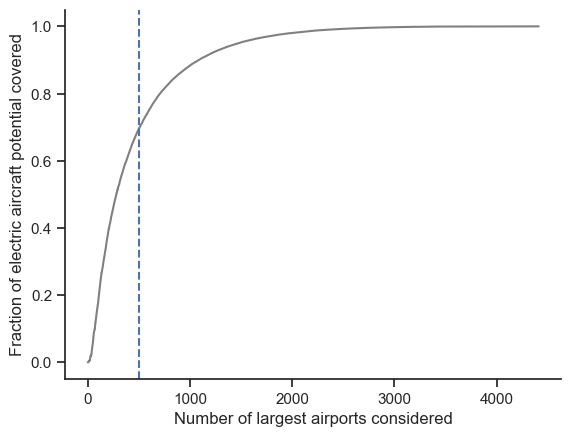

In [16]:
%matplotlib inline
# Plotting
plt.clf()
fig, ax= plt.subplots()

ax.plot(n_airport,score_0, color='grey')

ax.set_xlabel('Number of largest airports considered')
ax.set_ylabel('Fraction of electric aircraft potential covered')
ax.axvline(x=500, linestyle='--')
# Show the plot

plt.show()
fig.savefig('naive_selection.pdf')

As it can be seen on the plot above, flights between two of the 500 largest airports (over 4411) cover around 70 % of the emissions potentially adressed by an electric aircraft.   
That is confirmed below.

In [17]:
top500_elec=top_elec[:500]

test_naive_df=flights_df_gp_elec[(flights_df_gp_elec['iata_arrival'].isin(top500_elec)) & (flights_df_gp_elec['iata_departure'].isin(top500_elec))].reset_index()
flights_df_gp_elec.loc[(flights_df_gp_elec['iata_arrival'].isin(top500_elec)) & (flights_df_gp_elec['iata_departure'].isin(top500_elec)), 'co2'].sum() / flights_df_gp_elec['co2'].sum()

0.6958618861081549

### b) Designing local networks
Next, we try to select these 500 airports a bit differently to potentially increase this share.  
We still consider the largest airports as before, but we also select the n neighbouring airports with the most potential around the major airports.  
Since they are counted in the "500 airports", so the number of "largest airports" decraeses.  
The idea behind this is to create local "battery electric aircraft" networks, where most flighst are operated by these aircraft rather than selecting large albeit isolated airports.

In [18]:
top_elec=flights_df_gp_elec.groupby('iata_departure')['co2'].sum().nlargest(50000).index.to_list()
df=flights_df_gp_elec.reset_index()
nmax=500

total_potential=flights_df_gp_elec['co2'].sum()

# Creating a list of largest neighbors for each airport to avoid a time consuming groupby inside of the loop. 
top_neighbors_lists={}
for ap in tqdm(top_elec):
    top_neighbors_lists[ap]=df[df['iata_departure'] == ap].groupby('iata_arrival')['co2'].sum().sort_values(ascending=False).index.to_numpy()


def smart_top(top, top_neighbors_lists, nmax, j):
    top_list = []
    i = 0
    count = 0
    while count < nmax:
        ap = top[i]
        if ap not in top_list:
            top_list.append(ap)
            count += 1
        destinations = top_neighbors_lists[ap][:j]
        for el in destinations:
            if count < nmax and el not in top_list:
                top_list.append(el)
                count += 1
        i += 1
    return top_list

score={}

## We perform the analysis to select 100,500,1000,2000 airports (sensitivity analysis)
for arpt in [100,500,1000,2000]:
    score_i=[]
    top_elec_i=top_elec[:arpt]
    for j in tqdm(range (0,30)):
        top_list=smart_top(top_elec_i, top_neighbors_lists, arpt, j)
        score_j = flights_df_gp_elec.loc[(flights_df_gp_elec['iata_arrival'].isin(top_list)) & (flights_df_gp_elec['iata_departure'].isin(top_list)), 'co2'].sum() 
        score_j = score_j / total_potential
        score_i.append(score_j)
    score[arpt]=score_i
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.06it/s]


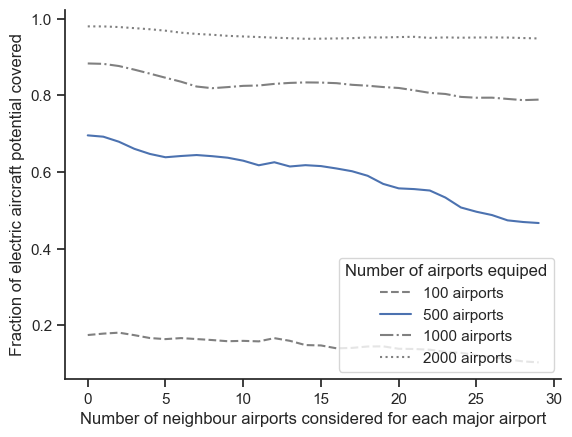

In [19]:
fig, ax = plt.subplots()

ax.plot(score[100], label='100 airports', color='grey', ls='--')
ax.plot(score[500], label='500 airports')
ax.plot(score[1000], label='1000 airports', color='grey',ls='-.')
ax.plot(score[2000], label='2000 airports', color='grey',ls=':')

ax.set_xlabel('Number of neighbour airports considered for each major airport')
ax.set_ylabel('Fraction of electric aircraft potential covered')

ax.legend(title='Number of airports equiped',loc='lower right')
# Show the plot
plt.show()

fig.savefig('neighbour_selection.pdf')

That is not conclusive. The best choice is still considering the 500 largest airports and none of their neighbours.
We are still able to see a "network effect" with the score increasing between 5 and 15 neighbors considered for 1000 airports selected, but the fraction of emissions covered is still 5% lower. Indeed, large airports are replaced by small airports in the selection, just because they are neighbors of large airports.

### c) Designing local networks - top routes only 
We try another improvement by following the same approach, but considering the routes only if they are in the top n routes, to avoid taking into account small airports served from big airports in the selection.

In [20]:
top_elec=flights_df_gp_elec.groupby('iata_departure')['co2'].sum().nlargest(500).index.to_list()
df=flights_df_gp_elec.reset_index()
nmax=500

total_potential=flights_df_gp_elec['co2'].sum()



def smart_top2(top, top_routes_neighbours_list, nmax, j):
    top_list = []
    i = 0
    count = 0
    while count < nmax:
        ap = top[i]
        if ap not in top_list:
            top_list.append(ap)
            count += 1
        destinations = top_routes_neighbors_lists[ap][:j]
        for el in destinations:
            if count < nmax and el not in top_list:
                top_list.append(el)
                count += 1
        i += 1
    return top_list



## We perform the analysis to select 100,500,1000,2000 airports (sensitivity analysis)
score_2={}
for n_routes in [500,1500, 2500, 500000]:
    
    # Creating a list of largest neighbors for each airport to avoid a time consuming groupby inside of the loop. 
    top_routes_neighbors_lists={}
    flights_df_gp_elec_top=flights_df_gp_elec.sort_values(by='co2').nlargest(n_routes, columns='co2').reset_index() 
    for ap in tqdm(top_elec):
        top_routes_neighbors_lists[ap]=flights_df_gp_elec_top[flights_df_gp_elec_top['iata_departure'] == ap].groupby('iata_arrival')['co2'].sum().sort_values(ascending=False).index.to_numpy()

    score_i=[]
    for j in tqdm(range (0,30)):
        top_list=smart_top2(top_elec, top_routes_neighbors_lists, 500, j)       
        score_j = flights_df_gp_elec.loc[(flights_df_gp_elec['iata_arrival'].isin(top_list)) & (flights_df_gp_elec['iata_departure'].isin(top_list)), 'co2'].sum() 
        score_j = score_j / total_potential
        score_i.append(score_j)
    score_2[n_routes]=score_i

    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 146.00it/s]


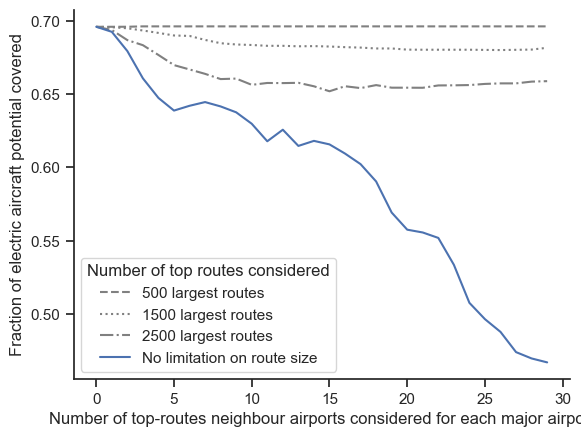

In [21]:
fig, ax = plt.subplots()

ax.plot(score_2[500], label='500 largest routes', color='grey', ls='--')
ax.plot(score_2[1500], label='1500 largest routes',color='grey',ls=':')
ax.plot(score_2[2500], label='2500 largest routes', color='grey',ls='-.')
ax.plot(score_2[500000], label='No limitation on route size')

ax.set_xlabel('Number of top-routes neighbour airports considered for each major airport')
ax.set_ylabel('Fraction of electric aircraft potential covered')

ax.legend(title='Number of top routes considered',loc='lower left')
# Show the plot
plt.show()
fig.savefig('neigbours-top.pdf')

The case with n=500 largest routes is equivalent to selecting 0 neigbours, meaning theses routes are only within the top 500 aiports group.
No clear trend is seen for the other groups considered, altough the performance is still lower than the naive case.  
**Even by restricing the choice to "busy" routes, the effect of large airports being traded for smaller airports is not compensated by any "network effect".**

### d) - Designing local networks - top airporsts only
The following code test the same approach, but selecting neighbours airports only if they are in the ith largest airports (i>500). It alows selecting local airports but not too small. The case where i=500 is thus the same than the approach b)

In [22]:
top_elec=flights_df_gp_elec.groupby('iata_departure')['co2'].sum().nlargest(50000).index.to_list()
df=flights_df_gp_elec.reset_index()
nmax=500

total_potential=flights_df_gp_elec['co2'].sum()

# Creating a list of largest neighbors for each airport to avoid a time consuming groupby inside of the loop. 
top_neighbors_lists={}
for ap in tqdm(top_elec):
    top_neighbors_lists[ap]=df[df['iata_departure'] == ap].groupby('iata_arrival')['co2'].sum().sort_values(ascending=False).index.to_numpy()


def smart_top3(top, top_large, top_neighbors_lists, nmax, j):
    top_list = []
    i = 0
    count = 0
    while count < nmax:
        ap = top[i]
        if ap not in top_list:
            top_list.append(ap)
            count += 1
        destinations = top_neighbors_lists[ap][:j]
        for el in destinations:
            if el in top_large:
                if count < nmax and el not in top_list:
                    top_list.append(el)
                    count += 1
        i += 1
    return top_list


score_3={}
for arpt in [500,800,1000,50000]:
    score_i=[]
    top_elec_i=top_elec[:500]
    top_large=top_elec[:arpt]
    for j in tqdm(range (0,30)):
        top_list=smart_top3(top_elec_i, top_large, top_neighbors_lists, 500, j)
        score_j = flights_df_gp_elec.loc[(flights_df_gp_elec['iata_arrival'].isin(top_list)) & (flights_df_gp_elec['iata_departure'].isin(top_list)), 'co2'].sum() 
        score_j = score_j / total_potential
        score_i.append(score_j)
    score_3[arpt]=score_i


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.94it/s]


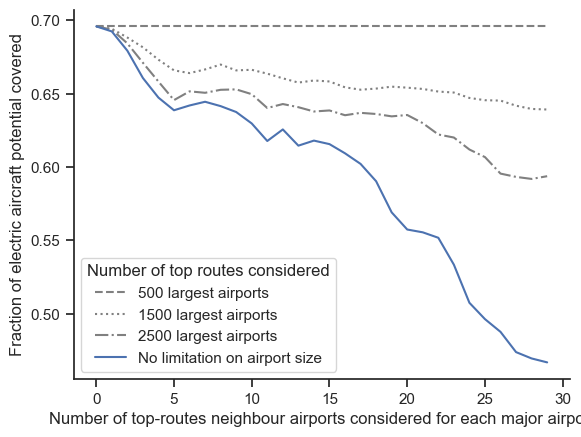

In [23]:
fig, ax = plt.subplots()

ax.plot(score_3[500], label='500 largest airports', color='grey', ls='--')
ax.plot(score_3[800], label='1500 largest airports',  color='grey',ls=':')
ax.plot(score_3[1000], label='2500 largest airports', color='grey',ls='-.')
ax.plot(score_3[50000], label='No limitation on airport size')

ax.set_xlabel('Number of top-routes neighbour airports considered for each major airport')
ax.set_ylabel('Fraction of electric aircraft potential covered')

ax.legend(title='Number of top routes considered',loc='lower left')
# Show the plot
plt.show()
fig.savefig('neigbours-top.pdf')

### Partial summary
We summarize the fours previous approaches in the figure below.  
- the leftmost plot represents the "naive" approach, with 500 airports selction being represented by the vertical line
- The center figure is the same approach, but the restriction is made on airport size themselves (Approach b (no limit) and d) 
- The rightmost figure is the selection of 500 airports, considering those linked to largest airports by a top route (Approach c) *(removed for easier figure understanding)*


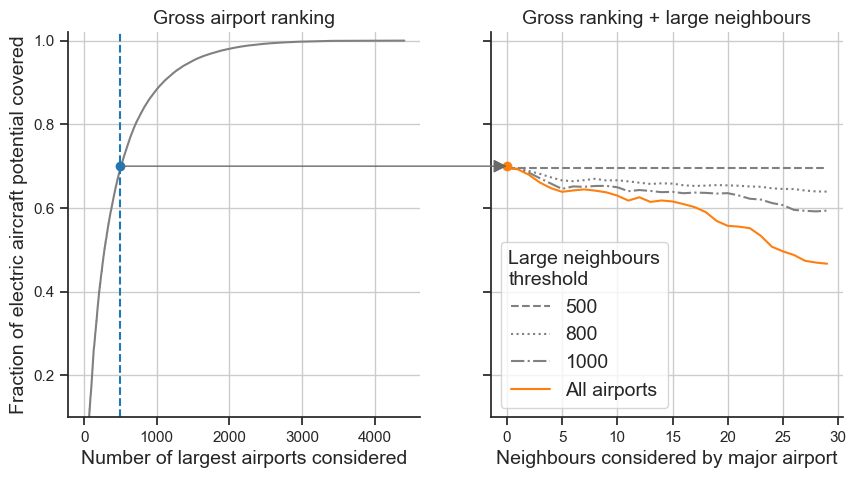

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot on each subplot
axs[0].plot(n_airport,score_0, color='grey')

axs[0].set_xlabel('Number of largest airports considered', fontsize=14)
axs[0].set_ylabel('Fraction of electric aircraft potential covered', fontsize=14)
axs[0].set_ylim([0.1,1.02])
axs[0].axvline(x=500, linestyle='--', color='tab:blue')
axs[0].grid(True)
axs[0].set_title('Gross airport ranking', fontsize=14)

axs[1].sharey(axs[0])
axs[1].plot(score_3[500], label='500', color='grey', ls='--')
axs[1].plot(score_3[800], label='800', color='grey',ls=':')
axs[1].plot(score_3[1000], label='1000', color='grey',ls='-.')
axs[1].plot(score_3[50000], label='All airports',  color='tab:orange')
axs[1].set_xlabel('Neighbours considered by major airport', fontsize=14)
axs[1].legend(title='Large neighbours\nthreshold', title_fontsize=14, fontsize=14,loc='lower left')
axs[1].set_title('Gross ranking + large neighbours', fontsize=14)
axs[1].grid(True)

from matplotlib import patches
xyA = [500, 0.7]
axs[0].plot(*xyA, "o", color='tab:blue')
xyB = [-0.0, 0.7]
axs[1].plot(*xyB, "o", color='tab:orange')
# ConnectionPatch handles the transform internally so no need to get fig.transFigure
arrow = patches.ConnectionPatch(
    xyA,
    xyB,
    coordsA=axs[0].transData,
    coordsB=axs[1].transData,
    # Default shrink parameter is 0 so can be omitted
    color="dimgrey",
    arrowstyle="-|>",  # "normal" arrow
    mutation_scale=20,  # controls arrow head size
    linewidth=1,
)
fig.patches.append(arrow)


# Last approach removed for clarity

# axs[2].plot(score_2[500], label='500', color='grey', ls='--')
# axs[2].plot(score_2[1500], label='1500', color='grey',ls=':')
# axs[2].plot(score_2[2500], label='2500', color='grey',ls='-.')
# axs[2].plot(score_2[500000], label='All routes')
# axs[2].grid(True)
# axs[2].set_xlabel('Max. top-routes neighbourgs considered by major airport')
# # axs[2].set_ylabel('Fraction of electric aircraft potential covered')
# axs[2].set_ylim([0.1,1.02])
# axs[2].legend(title='Largest routes\nthreshold',loc='lower left', fontsize=9)
# axs[2].set_title('Gross ranking + largest top-routes neighbours')


fig.savefig('airport_optim.pdf', bbox_inches='tight')

### e) Optimization approach

In [25]:
top_neighbors_lists={}
for ap in tqdm(flights_df_gp_elec.iata_departure.unique()):
    top_neighbors_lists[ap]=flights_df_gp_elec[flights_df_gp_elec['iata_departure'] == ap].groupby('iata_arrival')['co2'].sum().sort_values(ascending=False).index.to_numpy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4411/4411 [00:14<00:00, 310.76it/s]


In [26]:
top_elec=flights_df_gp_elec.groupby('iata_departure')['co2'].sum().nlargest(500).index.to_list()
df=flights_df_gp_elec.reset_index()
nmax=500
n_neighbours=np.ones(len(top_elec))*4

total=flights_df_gp_elec['co2'].sum()

def find_score(top, nmax, n_neighbours, return_df=False):
    top_list = []
    i = 0
    count = 0
    while count < nmax and i<len(top):
        if n_neighbours[i]>-1:
            ap = top[i]
            if ap not in top_list:
                top_list.append(ap)
                count += 1
            destinations = top_neighbors_lists[ap][:int(n_neighbours[i])]
            for el in destinations:
                if count < nmax and el not in top_list:
                    top_list.append(el)
                    count += 1
        i += 1
        
    score_i = flights_df_gp_elec.loc[(flights_df_gp_elec['iata_arrival'].isin(top_list)) & (flights_df_gp_elec['iata_departure'].isin(top_list)), 'co2'].sum() / total * 100
    if count<nmax:
        score_i=score_i/2 # penalize solution that are not selecting nmax airports (possible since i be the loop exit first)
    if return_df:
        test_df=flights_df_gp_elec[(flights_df_gp_elec['iata_arrival'].isin(top_list)) & (flights_df_gp_elec['iata_departure'].isin(top_list))].reset_index()
        return (score_i, test_df)
    else:
        return score_i

In [27]:
# import numpy as np
# from geneticalgorithm import geneticalgorithm as ga

# def objective_function(n_neighbours_vars):
#     return -find_score(top_elec, nmax, n_neighbours_vars)

# varbound=np.array([[-1,10]]*len(top_elec))


# algorithm_param = {'max_num_iteration': None,\
#                    'population_size':100,\
#                    'mutation_probability':0.05,\
#                    'elit_ratio': 0.08,\
#                    'crossover_probability': 0.5,\
#                    'parents_portion': 0.1,\
#                    'crossover_type':'uniform',\
#                    'max_iteration_without_improv':200}

# # Create the genetic algorithm
# model = ga(function=objective_function, dimension=len(top_elec), variable_type='int', variable_boundaries=varbound, algorithm_parameters=algorithm_param)

# # Run the genetic algorithm
# model.run()

In [28]:
# score, test_df = find_score(top_elec, df, nmax, model.output_dict['variable'], return_df=True)

In [85]:
import cma
import random
import numpy as np

# Objective function to maximize
def objective_function(n_neighbours_vars):
    return -find_score(top_elec, nmax, n_neighbours_vars)

# Parameters
n_vars = len(top_elec)
initial_solution = [0 for _ in range(nmax)]
options = {'popsize': 200, 'maxiter': 1000}

# Run CMA-ES
xopt, es = cma.fmin2(objective_function, initial_solution, 2, options=options)

(100_w,200)-aCMA-ES (mu_w=52.6,w_1=4%) in dimension 500 (seed=692045, Thu Jan 18 19:11:38 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    200 -2.864852937035237e+01 1.0e+00 1.90e+00  2e+00  2e+00 0:01.3
    2    400 -2.953299825347084e+01 1.0e+00 1.84e+00  2e+00  2e+00 0:02.5
    3    600 -2.978635640736776e+01 1.0e+00 1.81e+00  2e+00  2e+00 0:03.8
    6   1200 -3.138456085723197e+01 1.0e+00 1.81e+00  2e+00  2e+00 0:07.6
    9   1800 -3.246725394322591e+01 1.0e+00 1.93e+00  2e+00  2e+00 0:12.1
   13   2600 -6.579637253107123e+01 1.0e+00 2.17e+00  2e+00  2e+00 0:18.3
   17   3400 -6.647515619333937e+01 1.0e+00 2.47e+00  2e+00  2e+00 0:24.5
   22   4400 -6.711811277544940e+01 1.0e+00 2.88e+00  3e+00  3e+00 0:32.5
   27   5400 -6.722881010167001e+01 1.0e+00 3.34e+00  3e+00  3e+00 0:41.3
   32   6400 -6.731164060145294e+01 1.0e+00 3.73e+00  4e+00  4e+00 0:51.1
   38   7600 -6.716806015722327e+01 1.0e+00 4.05e+00  4e+00  4e+00 1:02.6
   44   8800 -6.79

In [91]:
neighbors_opt=xopt

In [92]:
scor, df = find_score(top_elec,  nmax, neighbors_opt, return_df=True)

In [93]:
scor

70.49901926279537

In [29]:
import cma
import random
# sensitivity of nmax?:

solutions_opt={}
score_opt={}
score_naive={}

for nmax in [25,50,100,250,500,1000]:
    # Objective function to maximize
    
    top_elec=flights_df_gp_elec.groupby('iata_departure')['co2'].sum().nlargest(nmax).index.to_list()
    
    def objective_function(n_neighbours_vars):
        return -find_score(top_elec, nmax, n_neighbours_vars)

    # Parameters
    n_vars = len(top_elec)
    initial_solution = [0 for _ in range(nmax)]
    options = {'popsize': 200, 'maxiter': 2000}

    # Run CMA-ES
    xopt, es = cma.fmin2(objective_function, initial_solution, 2, options=options)
    solutions_opt[nmax]=xopt
    score_opt[nmax]=find_score(top_elec, nmax, xopt)
    score_naive[nmax]=flights_df_gp_elec.loc[(flights_df_gp_elec['iata_arrival'].isin(top_elec)) & (flights_df_gp_elec['iata_departure'].isin(top_elec)), 'co2'].sum() / flights_df_gp_elec['co2'].sum() *100



(100_w,200)-aCMA-ES (mu_w=52.6,w_1=4%) in dimension 25 (seed=776488, Fri Jan 19 08:50:51 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    200 -3.923800946160926e+00 1.0e+00 2.37e+00  2e+00  2e+00 0:01.2
    2    400 -4.249653533135370e+00 1.2e+00 3.00e+00  3e+00  3e+00 0:02.4
    3    600 -4.460109723430745e+00 1.3e+00 3.57e+00  3e+00  4e+00 0:03.7
    6   1200 -5.280521307209161e+00 1.5e+00 7.33e+00  7e+00  8e+00 0:07.5
   10   2000 -5.152352457925568e+00 1.7e+00 1.64e+01  1e+01  2e+01 0:12.7
   14   2800 -5.261603699888848e+00 1.9e+00 2.75e+01  2e+01  3e+01 0:18.2
   19   3800 -5.297880374797167e+00 2.6e+00 4.58e+01  3e+01  6e+01 0:24.7
   24   4800 -5.297880374797167e+00 3.5e+00 5.30e+01  3e+01  7e+01 0:31.9
   30   6000 -5.391884570264791e+00 4.6e+00 5.96e+01  3e+01  9e+01 0:40.0
   37   7400 -5.297880374797167e+00 5.2e+00 5.87e+01  3e+01  8e+01 0:49.2
   45   9000 -5.297880374797167e+00 7.1e+00 6.29e+01  2e+01  8e+01 0:59.6
   54  10800 -5.297

In [34]:
top_elec=flights_df_gp_elec.groupby('iata_departure')['co2'].sum().nlargest(500).index.to_list()
score, df = find_score(top_elec,  500, solutions_opt[500], return_df=True)

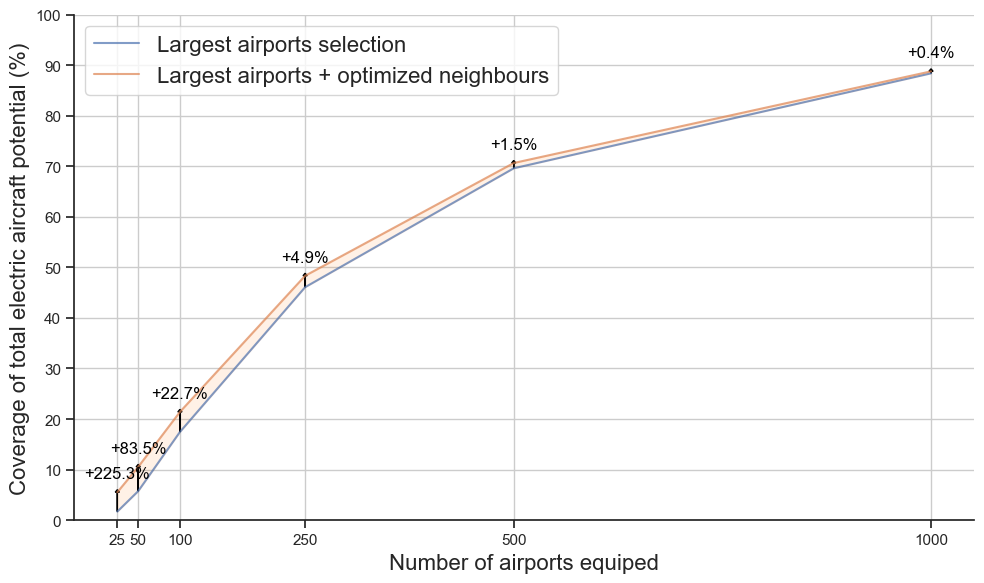

In [31]:
x_values = list(score_naive.keys())
naive = np.array(list(score_naive.values()))
optim = np.array(list(score_opt.values()))


improvement = optim - naive
improvement_ratio = improvement / naive * 100


fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_values, naive, label="Largest airports selection", alpha=0.7)
ax.plot(x_values, optim, label="Largest airports + optimized neighbours", alpha=0.7)
ax.fill_between(x_values, naive, optim, where=(improvement > 0), color='tab:orange', alpha=0.1)

for x, y_naive, y_opt, y_imp, y_imp_sh in zip(x_values, naive, optim, improvement, improvement_ratio):
    ax.arrow(x, y_naive, 0, y_imp, color='black', width=0.05, head_width=5, head_length=0.5, alpha=1)
    ax.annotate(f'+{y_imp_sh:.1f}%', (x, y_naive + y_imp), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=12, color='black')

ax.set_xlabel('Number of airports equiped', fontsize=16)
ax.set_ylabel('Coverage of total electric aircraft potential (%)', fontsize=16)
# ax.set_title('Comparison of Naive and Optimized coverage and relative improvement')


ax.legend(loc='upper left', fontsize=16)
ax.set_ylim(0,100)


custom_xticks = [25, 50, 100, 250, 500, 1000]
ax.set_xticks(custom_xticks)

custom_yticks = [x for x in range(0,110,10)]
ax.set_yticks(custom_yticks)
ax.grid()

fig.tight_layout()
fig.savefig('optimized_selection.pdf')

### f) Visual comparison of naive and 'optimized networks'

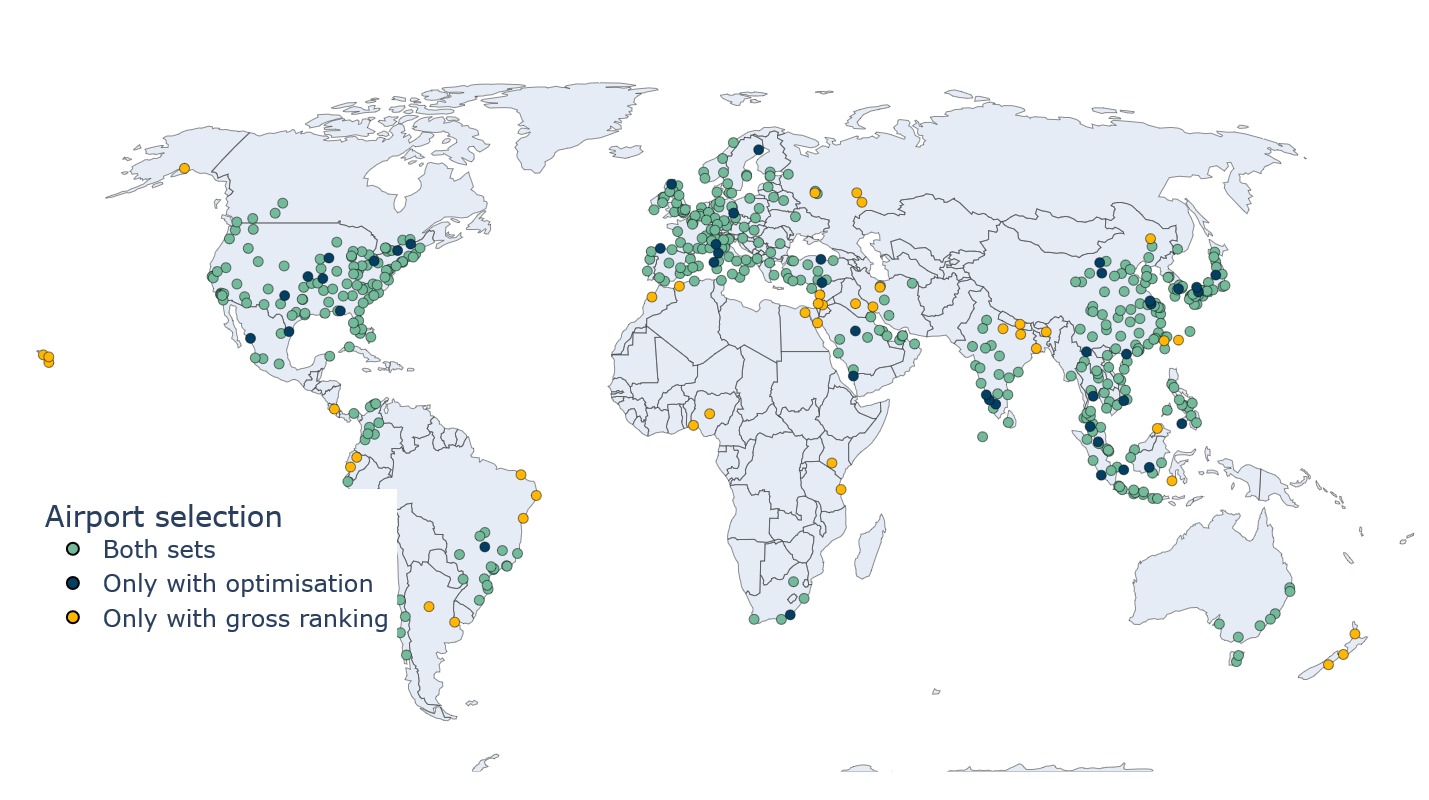

In [35]:
flights_gpb_naive_df=test_naive_df.copy()
flights_gpb_df=df.copy()

# # Create the scattergeo figure
fig = go.Figure()


airport_df = flights_gpb_df.groupby('iata_arrival').agg({
    'co2': 'sum',
    'ask': 'sum',
    'seats': 'sum',
    'arrival_lon': 'first',
    'arrival_lat': 'first'}).reset_index()


airport_naive_df = flights_gpb_naive_df.groupby('iata_arrival').agg({
    'co2': 'sum',
    'ask': 'sum',
    'seats': 'sum',
    'arrival_lon': 'first',
    'arrival_lat': 'first'}).reset_index()


merged_df=airport_df.merge(airport_naive_df, on='iata_arrival', how='outer', suffixes=('_op','_na'))
both_df=merged_df.dropna()
right_df=merged_df[merged_df['co2_op'].isna()]
left_df=merged_df[merged_df['co2_na'].isna()]


fig.add_trace(go.Scattergeo(
    lon=both_df['arrival_lon_op'],
    lat=both_df['arrival_lat_op'],
    hoverinfo='text',
    text=both_df['iata_arrival'],
    mode='markers',
    marker=dict(
        size=10,
        color='#73BA9B',
        sizemode='area',
        opacity=1,
        line=dict(width=0.5, color='black'),
    ),
    name='Both sets'

))

fig.add_trace(go.Scattergeo(
    lon=left_df['arrival_lon_op'],
    lat=left_df['arrival_lat_op'],
    hoverinfo='text',
    text=left_df['iata_arrival'],
    mode='markers',
    marker=dict(
        size=10,
        color='#033F63',
        sizemode='area',
        opacity=1,
        line=dict(width=0.5, color='black'),
    ),
    name="Only with optimisation"
))



fig.add_trace(go.Scattergeo(
    lon=right_df['arrival_lon_na'],
    lat=right_df['arrival_lat_na'],
    hoverinfo='text',
    text=right_df['iata_arrival'],
    mode='markers',
    marker=dict(
        size=10,
        color='#ffb703',
        sizemode='area',
        opacity=1,
        line=dict(width=0.5, color='black'),
    ),
    name="Only with gross ranking" 

))




# Update layout for a better display
fig.update_layout(
    margin=dict(r=0, l=0, b=0, t=0),
    legend=dict(
        title='Airport selection',
        x=0.03,
        y=0.2,
        font=dict(size=24),  # Adjust the font size
        xanchor='left',
        yanchor='bottom',
        itemclick='toggleothers',  # Allows clicking to toggle visibility
        traceorder='normal',  # Adjust the order of legend entries
        orientation='v',  # Vertical orientation
        itemsizing='constant',  # Keep legend items constant size
        itemwidth=50  # Adjust item width
    ),
    height=800, 
    width=1600
)



fig.update_layout(
    geo=dict(
        showland=True,
        bgcolor='white',
        countrywidth=0.6,
         projection=dict(type='natural earth', )
        # projection_scale=1.2,  # Adjust the zoom level
    ),
)


fig.update_geos(fitbounds='locations',showcountries=True, visible=False)

fig.write_image("network_airports_selected.pdf", format='pdf', width=1600)
fig

In [360]:
both_df

iata_arrival        co2_op        ask_op      seats_op  arrival_lon_op  \
0            ABQ  9.665714e+07  9.640031e+08  1.388036e+06     -106.609001   
1            ABZ  6.211046e+07  6.351259e+08  1.074535e+06       -2.197780   
2            ADA  1.410919e+08  1.542618e+09  2.598793e+06       35.280399   
3            ADB  2.218320e+08  2.049420e+09  4.715829e+06       27.157000   
4            ADL  9.904658e+07  1.003589e+09  1.562932e+06      138.533393   
..           ...           ...           ...           ...             ...   
494          YYZ  2.560837e+08  2.056560e+09  3.926479e+06      -79.630600   
495          ZAG  4.490732e+07  4.627955e+08  8.078042e+05       16.068800   
497          ZRH  4.978786e+08  4.844160e+09  8.801065e+06        8.548056   
498          ZUH  9.076961e+07  9.057588e+08  1.456222e+06      113.375999   
499          ZYI  5.720737e+07  6.298836e+08  7.965125e+05      107.000700   

     arrival_lat_op        co2_na        ask_na      seats_na  arrival_lon_na  \
0         35.040199  9.663821e+07  9.638407e+08  1.387718e+06     -106.609001   
1         57.201900  6.211046e+07  6.351259e+08  1.074535e+06       -2.197780   
2         36.982201  1.429526e+08  1.557661e+09  2.641018e+06       35.280399   
3         38.292400  2.163136e+08  1.978764e+09  4.633353e+06       27.157000   
4        -34.947512  9.904658e+07  1.003589e+09  1.562932e+06      138.533393   
..              ...           ...           ...           ...             ...   
494       43.677200  2.560633e+08  2.056480e+09  3.926297e+06      -79.630600   
495       45.742901  4.487980e+07  4.624793e+08  8.073060e+05       16.068800   
497       47.458056  4.920945e+08  4.793573e+09  8.708534e+06        8.548056   
498       22.006399  9.076961e+07  9.057588e+08  1.456222e+06      113.375999   
499       27.589500  5.662486e+07  6.231992e+08  7.889645e+05      107.000700   

     arrival_lat_na  
0         35.040199  
1         57.201900  
2         36.982201  
3         38.292400  
4        -34.947512  
..              ...  
494       43.677200  
495       45.742901  
497       47.458056  
498       22.006399  
499       27.589500  

[450 rows x 11 columns]

In [338]:
elements_not_in_naive = set(flights_gpb_df.iata_departure.unique()) - set(flights_gpb_naive_df.iata_departure.unique())
elements_not_in_optim = set(flights_gpb_naive_df.iata_departure.unique()) - set(flights_gpb_df.iata_departure.unique())

In [339]:
elements_not_in_naive

{'AHO',
 'ALB',
 'BAV',
 'BIA',
 'BKS',
 'BTV',
 'CAE',
 'CHO',
 'CIF',
 'CJJ',
 'CNN',
 'CUL',
 'CZX',
 'DLI',
 'DRS',
 'DSM',
 'ELQ',
 'GIZ',
 'GOA',
 'GPT',
 'HIJ',
 'HIN',
 'HTY',
 'ICT',
 'IZO',
 'JHG',
 'KIJ',
 'LBB',
 'LEJ',
 'LGK',
 'MFE',
 'MHT',
 'ODS',
 'PKY',
 'SGF',
 'SRQ',
 'SXB',
 'SYR',
 'SZF',
 'TAK',
 'UDI',
 'UTP',
 'UYN',
 'VPS',
 'XFN',
 'XUZ',
 'YCU',
 'YNJ',
 'YTY',
 'ZAM'}

In [335]:
elements_not_in_optim

['SJO',
 'BEY',
 'CCU',
 'AKL',
 'WLG',
 'KOA',
 'GAU',
 'LKO',
 'SSA',
 'JNB',
 'KTM',
 'DAR',
 'REC',
 'SSH',
 'UPG',
 'CPT',
 'ABV',
 'GYE',
 'BKI',
 'PAT',
 'COR',
 'HNL',
 'NBO',
 'MLE',
 'VVO',
 'HRB',
 'AEP',
 'KZN',
 'OGG',
 'VKO',
 'ANC',
 'KUF',
 'FOR',
 'IKA',
 'UIO',
 'CHC',
 'PLZ',
 'AMM',
 'CMN',
 'DUR',
 'ORN',
 'LOS',
 'NJF',
 'TLV',
 'RMQ',
 'AWZ',
 'CAI',
 'NTG']

In [336]:
len(flights_gpb_df.iata_arrival.unique())

500

In [337]:
len(flights_gpb_naive_df.iata_arrival.unique())

498

Note that the number of airports selected is below 500 in naive case. 
This is normal: in the naïve approach some airports can be isolated, and depite being in the top 500 potential, they have no neighbour in the set

In the opimization process, the number of 'node' airports is limited to 500 to fix the size of the optimisation ariables vector. Thus if this limit is reached before the total number of airports selected is equal to 500 (for instance if the solution being tested rejects a lot of main airports), the total number of airports selected could be below 500. However, these solutions are now pennalized in the fins_score function. 

In [38]:
test_naive_df[test_naive_df.iata_departure=='ANC']


index iata_departure iata_arrival  co2  ask   seats  arrival_lon  \
190   4273            ANC          ANC  0.0  0.0  2972.0  -149.996002   

     arrival_lat  departure_lon  departure_lat  distance_km  
190      61.1744    -149.996002        61.1744          0.0